## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Каспарян Роман Эрвинович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

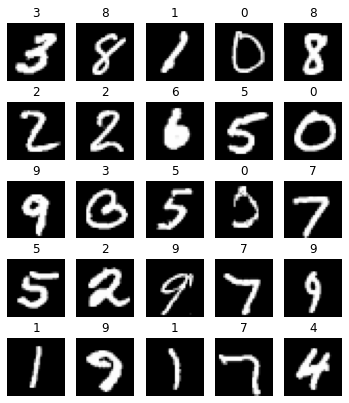

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [21]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [22]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9935088753700256
forward 0.7713884711265564
forward 0.6081933975219727
forward 0.39473065733909607
forward 0.3094464838504791
forward 0.14754435420036316
forward 0.09179355204105377
forward 0.05811911076307297
forward 0.03652450442314148
forward 0.019772086292505264
forward 0.017354954034090042
forward 0.014863148331642151
forward 0.01429114118218422
forward 0.014481253921985626
forward 0.006479367613792419
forward 0.005633276421576738
forward 0.0050393943674862385
forward 0.003250038716942072
forward 0.0026243277825415134
forward 0.0013344712788239121
forward 0.001071765087544918
forward 0.000742415664717555
forward 0.0007781670428812504
forward 0.0007051847060211003
forward 0.000304351415252313
forward 0.00029335790895856917
forward 0.00010826624929904938
forward 2.3888769646873698e-05
forward 1.7129552361438982e-05
forward 1.2362516827124637e-05
forward 9.037966265168507e-06
forward 7.404573352687294e-06
forward 4.353517397248652e-06
backward 0.03559025749564171
backward 0

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [20]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def he(size_input, size_output):
    d = 2 / (size_input)
    return np.sqrt(d)

init_func = he

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

66
forward 0.9935088753700256
forward 0.8805041909217834
forward 0.8708478808403015
forward 0.7843828797340393
forward 0.7836576104164124
forward 0.553686797618866
forward 0.490163654088974
forward 0.3116450607776642
forward 0.2306130975484848
forward 0.204381063580513
forward 0.16571100056171417
forward 0.04406856372952461
forward 0.04325443133711815
forward 0.036526862531900406
forward 0.03654324635863304
forward 0.022086655721068382
forward 0.015588108450174332
forward 0.014881831593811512
forward 0.013759661465883255
forward 0.019777199253439903
forward 0.021589655429124832
forward 0.016370289027690887
forward 0.017611971125006676
forward 0.007797847501933575
forward 0.005637879949063063
forward 0.0067504593171179295
forward 0.0052946037612855434
forward 0.0024418544489890337
forward 0.0025343536399304867
forward 0.002168310107663274
forward 0.0019594901241362095
forward 0.0025576918851584196
forward 0.0021871686913073063
backward 0.03559025749564171
backward 0.0600203201174736
bac

In [23]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def xvr(size_input, size_output):
    d = 1 / (size_input)
    return np.sqrt(d)

init_func = xvr

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

66
forward 0.9935088753700256
forward 0.6003461480140686
forward 0.34785833954811096
forward 0.18358631432056427
forward 0.11682165414094925
forward 0.07139107584953308
forward 0.049379900097846985
forward 0.030032865703105927
forward 0.021660512313246727
forward 0.012552298605442047
forward 0.006885887589305639
forward 0.004780151881277561
forward 0.005372896324843168
forward 0.0038691603112965822
forward 0.001178380916826427
forward 0.0006032588426023722
forward 0.0002194706758018583
forward 0.00014701829059049487
forward 0.00010741793812485412
forward 6.740525714121759e-05
forward 4.5656237489311025e-05
forward 1.6564064935664646e-05
forward 1.2003321899101138e-05
forward 5.251592483546119e-06
forward 5.320424406818347e-06
forward 2.937149247372872e-06
forward 1.581828996677359e-06
forward 8.764718018028361e-07
forward 3.6176933804199507e-07
forward 2.0570382730511483e-07
forward 1.3337779591893195e-07
forward 6.681990072365807e-08
forward 4.4363265061519996e-08
backward 0.035590257

В данном случае лучше сработал "бескомпромиссный" xavier (sqrt(1/ni)) 

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [24]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
    
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
    
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [25]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [26]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.144/0.281	Accuracy: 0.955/0.973


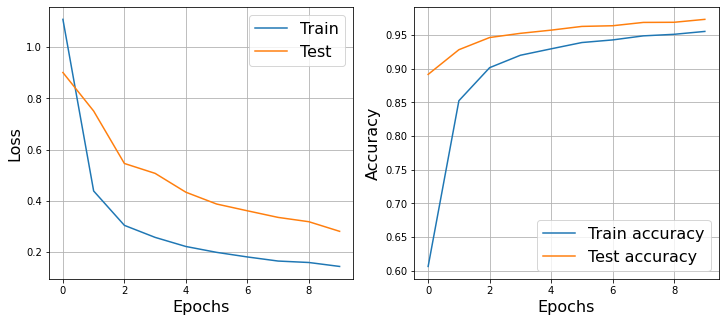

CPU times: user 3min 4s, sys: 3.27 s, total: 3min 8s
Wall time: 4min 16s


([1.1081612268998933,
  0.4382935313146506,
  0.30414681756166,
  0.2571966414099563,
  0.2216702597354775,
  0.19878708826961802,
  0.18084855526209132,
  0.16485233133090837,
  0.1591976049469351,
  0.14379499999206585],
 [0.9006247620062926,
  0.7503268604602995,
  0.5456740092714466,
  0.507055205917811,
  0.4334876293425531,
  0.38739615329835986,
  0.3610148707145377,
  0.3351998763869981,
  0.31835469399001215,
  0.28085699087377974],
 [0.60630447,
  0.85250086,
  0.9016247,
  0.9200538,
  0.92960423,
  0.9389604,
  0.9428416,
  0.94887173,
  0.95117605,
  0.9554737],
 [0.8916139,
  0.928303,
  0.94640034,
  0.9526305,
  0.9573774,
  0.96291536,
  0.96390426,
  0.9688489,
  0.96904665,
  0.973398])

In [27]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.438/0.061	Accuracy: 0.783/0.982


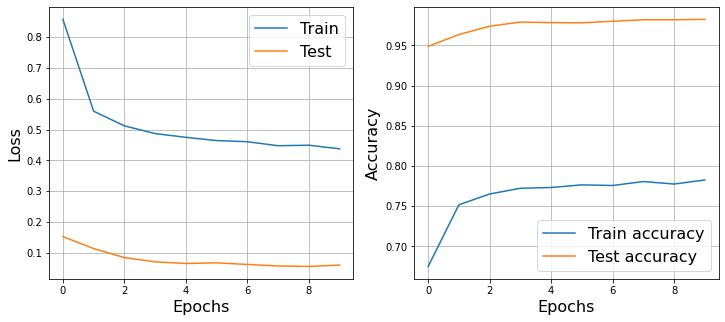

CPU times: user 1min 51s, sys: 439 ms, total: 1min 51s
Wall time: 1min 51s


In [15]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.154/0.332	Accuracy: 0.952/0.969


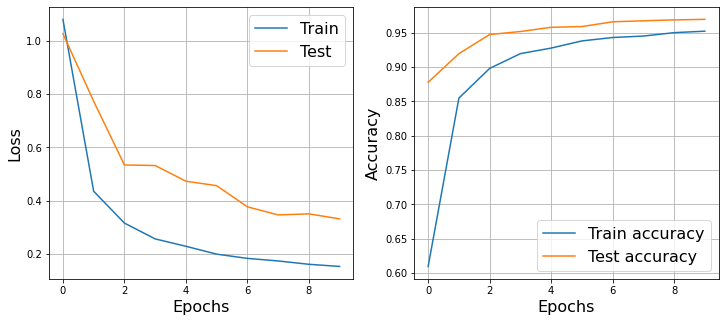

CPU times: user 1min 54s, sys: 413 ms, total: 1min 54s
Wall time: 1min 54s


In [17]:
%%time

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [127]:
# полезные функции: .std(dim), .mean(dim)
import math

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = x
        for i in range(len(x)):
            output[i] = (x[i] - torch.mean(x[i]))/math.sqrt(torch.std(x[i]))
        return output
    
class BatchNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean())/torch.sqrt(x.std())
        return output


3.2 Сравните графики обучения нейроных сетей:

   1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 

   2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 

In [128]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [129]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layer = LayerNormalization()
    
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.087/0.084	Accuracy: 0.973/0.974


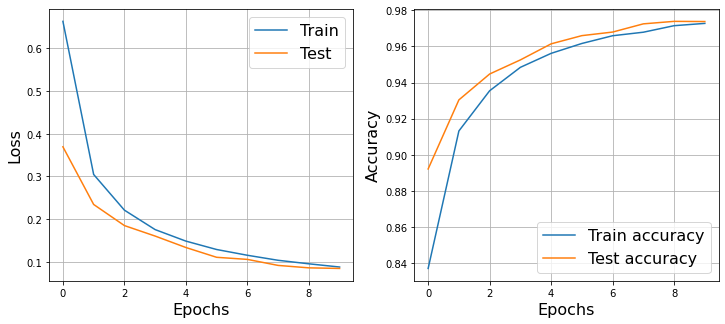

CPU times: user 15min 40s, sys: 759 ms, total: 15min 41s
Wall time: 15min 42s


([0.6632686359351123,
  0.30434319697844703,
  0.22071187225168448,
  0.1751016595724549,
  0.14811943996467317,
  0.12844331161395064,
  0.11494332295395672,
  0.10316545285109772,
  0.09491180883112874,
  0.0873733520595186],
 [0.3692056185837033,
  0.2340288451766666,
  0.18454852535188954,
  0.15993966954418376,
  0.13313804420677922,
  0.110169893578638,
  0.10527623911635785,
  0.09116075355323809,
  0.08544301074233991,
  0.08404950591252197],
 [0.83698696,
  0.913163,
  0.93543446,
  0.94841635,
  0.9561623,
  0.96163714,
  0.9659237,
  0.9678783,
  0.971493,
  0.97276455],
 [0.8921084,
  0.93037975,
  0.94471914,
  0.95253164,
  0.961432,
  0.965981,
  0.96795887,
  0.9725079,
  0.9738924,
  0.9737935])

In [130]:
%%time

#layer_normalization
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [102]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layer = BatchNormalization()
    
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.033/0.060	Accuracy: 0.990/0.981


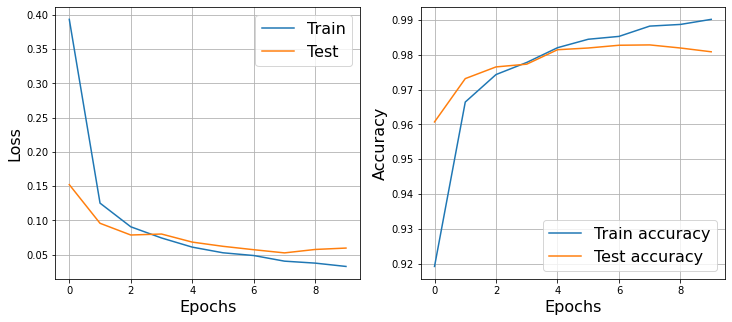

CPU times: user 2min 53s, sys: 330 ms, total: 2min 53s
Wall time: 2min 53s


([0.39338599687128434,
  0.12528464017010954,
  0.09076327101381094,
  0.07444994391869507,
  0.061077569194360457,
  0.05283538910792644,
  0.04883494278562984,
  0.04062751774836991,
  0.03775078244705889,
  0.032909793276856066],
 [0.15228186444013933,
  0.09587525217970715,
  0.0787708070364934,
  0.08020244357235069,
  0.06841895150468696,
  0.06227322910688346,
  0.05731674271954011,
  0.052689529283420196,
  0.05770306805549543,
  0.05971254519469847],
 [0.9191653,
  0.9664568,
  0.9743637,
  0.9778507,
  0.9820874,
  0.98451936,
  0.98534113,
  0.9883007,
  0.9887838,
  0.9902441],
 [0.96073973,
  0.97320014,
  0.9765625,
  0.97735363,
  0.9815071,
  0.9820016,
  0.98279274,
  0.9828916,
  0.9820016,
  0.98091376])

In [75]:
%%time

#batch_normalization
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

в данном случае batch_normalization сработала лучше

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: